In [61]:
import pandas as pd
from utils import ftextraction
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Imputer
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from utils import plotting
import numpy as np
import gc
gc.enable()

##### Preprocess datasets 

In [2]:
fe = ftextraction.Extractor()

In [3]:
#load datasets
start = time.time()
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
buro = pd.read_csv('data/bureau.csv')
bb = pd.read_csv('data/bureau_balance.csv')
ccb = pd.read_csv('data/credit_card_balance.csv')
ipay = pd.read_csv('data/installments_payments.csv')
pos = pd.read_csv('data/POS_CASH_balance.csv')
pa = pd.read_csv('data/previous_application.csv')
end = time.time()
print('Datasets loaded in: {:.2f} minutes'.format((end-start)/60))

Datasets loaded in: 0.93 minutes


In [4]:
#process datasets
start = time.time()
# data = fe.process_datasets(app_train,app_test,buro,bb,pa,ipay,ccb,pos,fe=False,path='processed/alldata.csv')
data_fe = fe.process_datasets(app_train,app_test,buro,bb,pa,ipay,ccb,pos,path='processed/alldata_fe.csv')
end = time.time()
print('Datasets processed in: {:.2f} minutes'.format((end-start)/60))

Aggregating data sets....


/home/ashique_mahmood93/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Aggregation done in 4.47 minutes 
Joining datasets.... 
Merge done in 8.11 minutes 
Datasets processed in: 26.19 minutes


In [3]:
data = pd.read_csv('processed/alldata.csv')
data_fe = pd.read_csv('processed/alldata_fe.csv')

In [63]:
vs = plotting.Visualizations()

##### Random Forest Baseline 

In [32]:
def rf_baseline(data):

    #preprocessing data    
    train = data.loc[data['TARGET'].notnull(),:].copy()
    test = data.loc[data['TARGET'].isnull(),:].copy()
    
    if data.shape[1] > 1847:
        drop = True
    del data
    gc.collect()

    labels = train['TARGET']

    train.drop(columns=['TARGET','SK_ID_CURR'],inplace=True)
    test.drop(columns=['TARGET','SK_ID_CURR'],inplace=True)
    
    #drop features with a high number of missing values:
    train = fe.drop_missing_values(train,30)
    test = fe.drop_missing_values(test,30)
    
    train,test = train.align(test,join='inner',axis=1)
    
    features = list(train.columns)
    
    #remove features dropped by imputer
    if drop:
        to_drop = [455,456,457,459,460,461,464]
        for ft in to_drop:
            del features[ft]
    
    # Impute training and testing data
    
    imputer = Imputer(strategy='mean',verbose=200)
    imputer.fit(train)
    train = imputer.transform(train)
    test = imputer.transform(test)
    
   
    fi = np.zeros(len(features))
    
    classifier = RandomForestClassifier()
    # converting to numpy array 
    train = np.array(train)
    test = np.array(test)
    
    scores = {}
    
    #splitting datasets
    x_train, x_valid, y_train, y_valid = train_test_split(train, labels, test_size=0.33, random_state=42)
    start = time.time()
    classifier.fit(x_train,y_train)
    #prediction on cv set
    cv_preds = classifier.predict_proba(x_valid)[:,1]
    #prediction on test set
    test_pred = classifier.predict_proba(test)[:,1]
    #prediction on training set
    train_pred = classifier.predict_proba(x_train)[:,1]
    end = time.time()
    print('Training done in {:.2f} minutes'.format((end-start)/60))
    #recording scores
    scores['training score'] = [roc_auc_score(y_train,train_pred)]
    scores['validation score'] = [roc_auc_score(y_valid,cv_preds)]
    print('Training score: {:.4f} | CV Score: {:.4f}'\
          .format(roc_auc_score(y_train,train_pred),roc_auc_score(y_valid,cv_preds)))
    #store feature importance
    fi = classifier.feature_importances_
    
    del x_train, x_valid, y_train, y_valid
    gc.collect()

    scores = pd.DataFrame.from_dict(scores)
    
    #feature importance
    f_importance = pd.DataFrame(columns=['feature','importance'])
    f_importance['features'] = features
    f_importance['importance'] = fi
    
    return scores,test_pred,f_importance

Modelling with all features:

In [16]:
rf_scores,rf_test_pred,rf_f_importance = rf_baseline(data)

Dropping 477 columns....
Dropping 405 columns....
Training done in 1.36 minutes
Training score: 0.9998 | CV Score: 0.6275


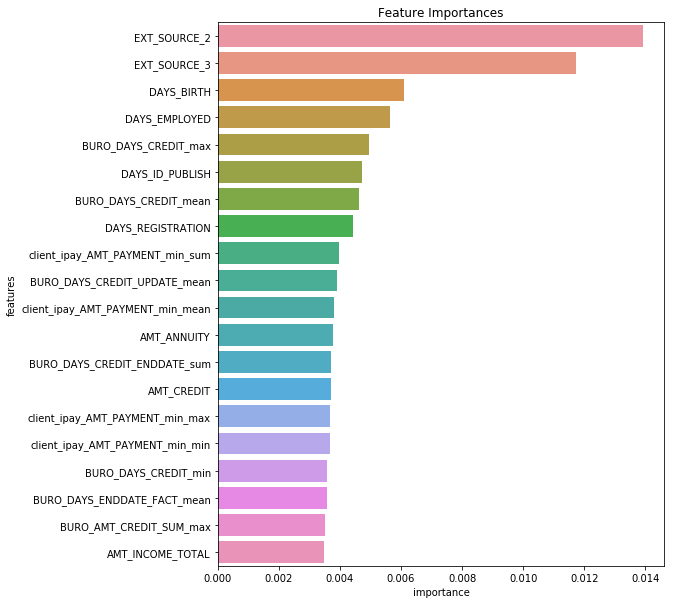

In [71]:
vs.plot_fi(rf_f_importance)

Modelling with engineered features:

In [33]:
rf_scores_fe,rf_test_pred_fe,rf_f_importance_fe = rf_baseline(data_fe)

Dropping 479 columns....
Dropping 407 columns....


/home/ashique_mahmood93/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/imputation.py:347: UserWarning: Deleting features without observed values: [455 456 457 459 460 461 464]
  "observed values: %s" % missing)


Training done in 1.43 minutes
Training score: 0.9998 | CV Score: 0.6393


In [37]:
submissions_rf = pd.read_csv('data/sample_submission.csv')
submissions_rf['TARGET'] = rf_test_pred_fe
submissions_rf.to_csv('submissions/submissions_rf_fe.csv',index=False)

##### Improved Modelling 

In [55]:
def lgbmV0(data,folds,exclude=[]):
       
    #preprocessing data    
    train = data.loc[data['TARGET'].notnull(),:].copy()
    test = data.loc[data['TARGET'].isnull(),:].copy()
    del data
    gc.collect()

    # save test IDs for final submission dataframe
    test_IDs = test['SK_ID_CURR']
    # save target labels
    labels = train['TARGET']
    # drop ID columns
    train = train.drop(columns=['SK_ID_CURR','TARGET'])
    test = test.drop(columns=['SK_ID_CURR'])


    # drop features with no importance
    train.drop(columns=exclude,inplace=True)
    test.drop(columns=exclude,inplace=True)

    # aligining dataframes
    train,test = train.align(test,join='inner',axis=1)

    # for storing feature importances
    features = list(train.columns)
    ft_importances = np.zeros(len(features))

    # converting to numpy array for lgbm consumptions
    train = np.array(train)
    test = np.array(test)

    #DATA STRUCTURES TO STORE PREDICTIONS AND METRICS

    #store cv predictions
    oof_predictions = np.zeros(train.shape[0])
    #store predictions on test dataset
    test_preds = np.zeros(test.shape[0])
    #store predictions on train dataset
    train_preds = np.zeros(train.shape[0])
    #store scores
    scores = {}

    #SPLITTING AND TRAINING 
    kfold = StratifiedKFold(n_splits=folds,shuffle=True,random_state=40)
    fold = 1
    start = time.time()
    print('Training started')
    for train_i,valid_i in kfold.split(train,labels):
        xtrain,ytrain = train[train_i],labels[train_i]
        xvalid,yvalid = train[valid_i],labels[valid_i]
        
        # creating the classifier 
        clf = lgbm.LGBMClassifier()

        # fitting on the training set, early stopping using validation set
        clf.fit(xtrain,ytrain,verbose= 200)

        # storing out of fold predictions:
        oof_predictions[valid_i] = clf.predict_proba(xvalid)[:, 1]

        # storing test set predictions:
        test_preds += clf.predict_proba(test)[:, 1] /kfold.n_splits

        #stortin training set predictions
        train_preds[train_i] = clf.predict_proba(xtrain)[:, 1]

        # storing feature importances            
        ft_importances += clf.feature_importances_ /kfold.n_splits
        print('Fold %d done.'%fold)
        fold += 1
        # freeing up memory
        del xtrain,ytrain,xvalid,yvalid,clf
        gc.collect()
        
    end = time.time()    
    print('Training done in {:.2f} minutes'.format((end-start)/60))    
    #SCORES

    feature_importances = pd.DataFrame({'features':features,'importance':ft_importances})
    
    training_score = roc_auc_score(labels,train_preds)
    cv = roc_auc_score(labels,oof_predictions)
    scores['training score'] = [training_score]
    scores['cv score'] = [cv]
    scores = pd.DataFrame.from_dict(scores)
    print('Overall CV Score: %.4f' %cv)
    # submission dataframe:
    submission = pd.DataFrame({'SK_ID_CURR': test_IDs, 'TARGET': test_preds})

    return submission, scores, feature_importances

Without engineered features

In [56]:
submission_lgbmV0, scores_lgbmV0, fi_lgbm_V0 = lgbmV0(data,5)

Training started
Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
Training done in 5.10 minutes
Overall CV Score: 0.7806


With engineered features

In [57]:
submission_lgbmV0_fe, scores_lgbmV0_fe, fi_lgbm_V0_fe = lgbmV0(data_fe,5)

Training started
Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
Training done in 5.25 minutes
Overall CV Score: 0.7829


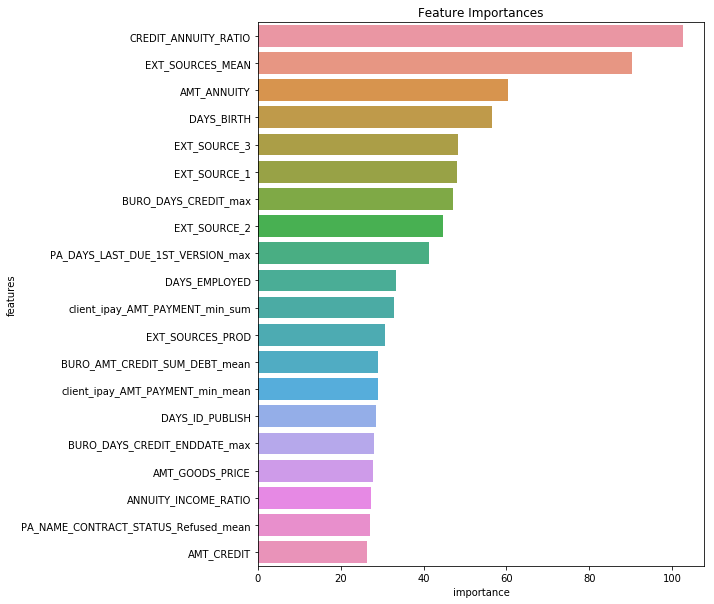

In [64]:
vs.plot_fi(fi_lgbm_V0_fe)